In [2]:
import numpy as np
import pandas as pd
from case_studies import *
import time


In [3]:
#Save case study functions, their derivatives and hessians in lists
fs = [f1, f2, f3, f4, f5]
dfs = [df1, df2, df3, df4, df5]
Hfs = [Hf1, Hf2, Hf3, Hf4, Hf5]
fnames = ["f1", "f2", "f3", "f4", "f5"]

In [4]:
def backtracking_line_search(f, df, x, pk, alpha_init, c1, rho):
    """
    Performs backtracking line search to find a suitable step size.
    
    Parameters:
        f: Function to minimize.
        grad_f: Gradient of f.
        x: Current point.
        p: Search direction.
        alpha_init: Initial step size.
        c1: Armijo condition parameter.
        rho: Reduction factor for step size.
    
    Returns:
        alpha: Suitable step size.
    """
    alpha = alpha_init
    while f(x + alpha * pk) > f(x) + c1 * alpha * np.dot(df(x), pk):
        alpha *= rho
    return alpha

## Steepest Descent

In [5]:
#Steepest Descent

def steepest_descent(f, df, x0, c1=0.01, rho=0.5, tol=1e-6, max_iters=1000):
    """
    Implements the Steepest Descent Algorithm with Backtracking Line Search.
    
    Parameters:
        f: Function to minimize.
        grad_f: Gradient of f.
        x0: Initial point.
        c1: Armijo condition parameter.
        rho: Reduction factor for step size.
        tol: Tolerance for stopping condition.
        max_iters: Maximum number of iterations.
    
    Returns:
        x: Estimated minimum.
        xs: List of iterates for analysis.
    """
    x=x0
    beta = 1.0
    xs = [x0]
    
    for _ in range(max_iters):
        pk = -df(x)
        if np.linalg.norm(pk) < tol:
            break
        
        alpha = backtracking_line_search(f, df, x, pk, beta, c1, rho)
        x = x + alpha * pk
        beta = alpha / rho
        xs.append(x)
    
    return x, xs


## Newton's Algorithm

In [6]:
#Newton's Algorithm

def newtons_method(f, grad_f, hessian_f, x0, c1=1e-4, rho=0.9, tol=1e-6, max_iters=1000):
    """
    Implements Newton's Method with a modified Hessian when necessary.
    
    Parameters:
        f: Function to minimize.
        grad_f: Gradient of f.
        hessian_f: Hessian (second derivative) of f.
        x0: Initial point.
        c1: Armijo condition parameter.
        rho: Reduction factor for step size.
        tol: Tolerance for stopping condition.
        max_iters: Maximum number of iterations.
    
    Returns:
        x: Estimated minimum.
        xs: List of iterates for analysis.
    """
    x = x0
    xs = [x0]
    
    for _ in range(max_iters):
        grad = grad_f(x)
        hessian = hessian_f(x)
        
        if np.linalg.norm(grad) < tol:
            break 
        
        if np.all(np.linalg.eigvals(hessian) > 0):
            p = -np.linalg.solve(hessian, grad)
        else:
            eigvals, eigvecs = np.linalg.eigh(hessian)
            H = sum((1 / abs(eigval)) * np.outer(eigvec, eigvec) for eigval, eigvec in zip(eigvals, eigvecs))
            p = -H @ grad
        
        alpha = backtracking_line_search(f, grad_f, x, p, 1.0, c1, rho)
        x = x + alpha * p
        xs.append(x)
    
    return x, xs

In [7]:
def benchmark(f, df, optimizer, x0, x_opt, Hf):
    start_time = time.time()

    if Hf is not None:
        x_final, xs = optimizer(f, df, Hf, x0)
    else:
        x_final, xs = optimizer(f, df, x0)

    end_time = time.time()

    num_iterations = len(xs)
    final_solution_point = x_final
    dist_to_optimum = np.linalg.norm(x_final-x_opt)
    final_fun_value = f(xs[-1])
    duration = end_time-start_time
    
    grad_norms = [np.linalg.norm(df(x)) for x in xs]

    return (num_iterations, duration, final_fun_value, final_solution_point, dist_to_optimum, grad_norms)


In [ ]:
x0 = np.random.randn(2) 
benchmark_results = []

for f, df, Hf, fname in zip(fs, dfs, Hfs, fnames):
    x_optimal = x_opt(fname, len(x0))

    sd_result = benchmark(f, df, steepest_descent, x0, x_optimal, Hf=None)
    benchmark_results.append((fname, "Steepest Descent") + sd_result)

for f, df, Hf, fname in zip(fs, dfs, Hfs, fnames):    
    x_optimal = x_opt(fname, len(x0))
    
    nm_result = benchmark(f, df, newtons_method, x0, x_optimal, Hf)
    benchmark_results.append((fname, "Newton's Method") + nm_result)

# Convert to DataFrame
columns = ["Function", "Optimizer", "Iterations", "Time", "Final Function Value", "Final Solution Point", "Distance to Optimum", "Gradient Norms"]
df_results = pd.DataFrame(benchmark_results, columns=columns)

df_results

,Function,Optimizer,Iterations,Time,Final Function Value,Final Solution Point,Distance to Optimum,Gradient Norms
0,f1,Steepest Descent,1001,0.246997,1.710249e-02,"[-0.1304892852444876, -0.0002739264017260053]",1.304896e-01,"[472.0974437427145, 449.9682587392595, 428.876..."
1,f2,Steepest Descent,1001,0.040004,2.008058e-03,"[0.955189606633818, 0.9123578157627545]",9.843335e-02,"[544.5193340081893, 47.38257804284586, 27.9804..."
2,f3,Steepest Descent,1001,0.358000,4.673389e+00,"[-0.10295810414628753, -7.496033793821311e-05]",1.029581e-01,"[8.32617873410663, 30.91796864722614, 12.03993..."
3,f4,Steepest Descent,12,0.004001,1.220319e-05,"[0.001909382756704566, 0.001909382756704566]",7.307522e-08,"[203.76208079650513, 10.697509241816519, 9.360..."
4,f5,Steepest Descent,13,0.001995,1.278318e-09,"[0.0, -0.0059794286036602955]",5.979429e-03,"[1.9828752135990377, 0.03690791902138832, 0.02..."
5,f1,Newton's Method,2,0.000000,0.000000e+00,"[0.0, 0.0]",0.000000e+00,"[472.0974437427145, 0.0]"
6,f2,Newton's Method,20,0.001997,3.145128e-24,"[0.999999999998228, 0.9999999999964488]",3.968729e-12,"[544.5193340081893, 3.9919630694791794, 37.871..."
7,f3,Newton's Method,15,0.007998,8.478718e-42,"[-1.8508166205873994e-23, -7.108583389127582e-25]",1.852181e-23,"[8.32617873410663, 14.011160771504374, 28.7668..."
8,f4,Newton's Method,8,0.003005,1.220319e-05,"[0.001909331076337135, 0.001909331076337135]",1.185752e-11,"[203.76208079650513, 0.09704555620337947, 0.03..."
9,f5,Newton's Method,10,0.002003,1.421366e-09,"[0.0, -0.006140114835881533]",6.140115e-03,"[1.9828752135990377, 0.015587615682043804, 0.0..."


Steepest Descent
Steepest Descent
Steepest Descent
Steepest Descent
Steepest Descent


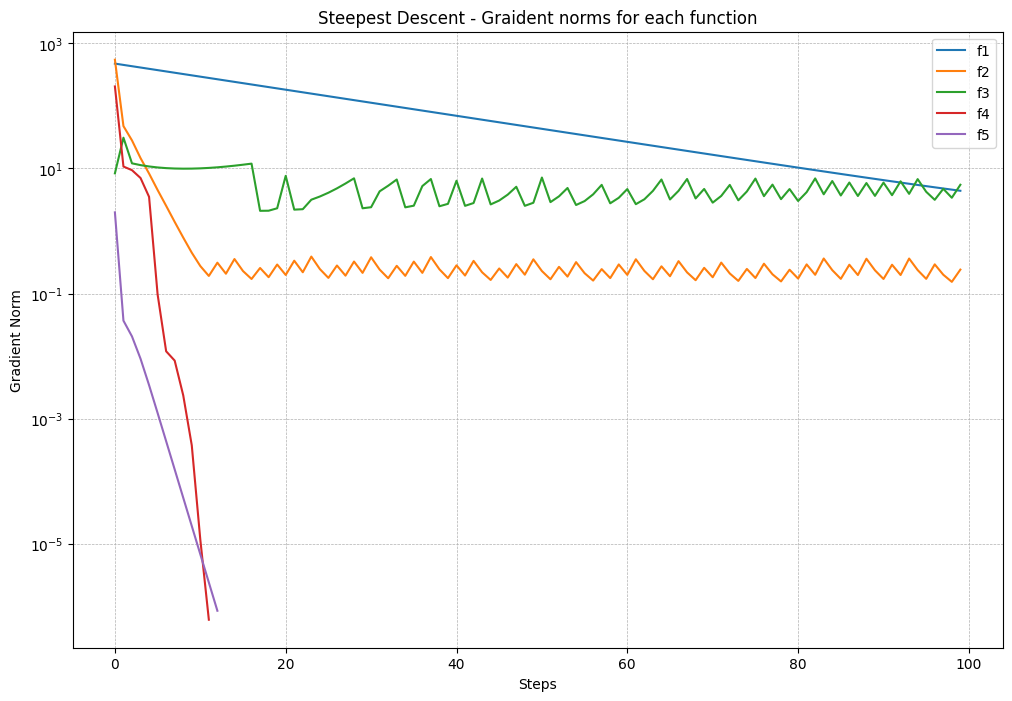

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.plot(range(len(df_results.iloc[i,7][:100])), df_results.iloc[i,7][:100], label=f"{df_results.iloc[i,0]}")
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.title("Steepest Descent - Graident norms for each function")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

Newton's Method
Newton's Method
Newton's Method
Newton's Method
Newton's Method


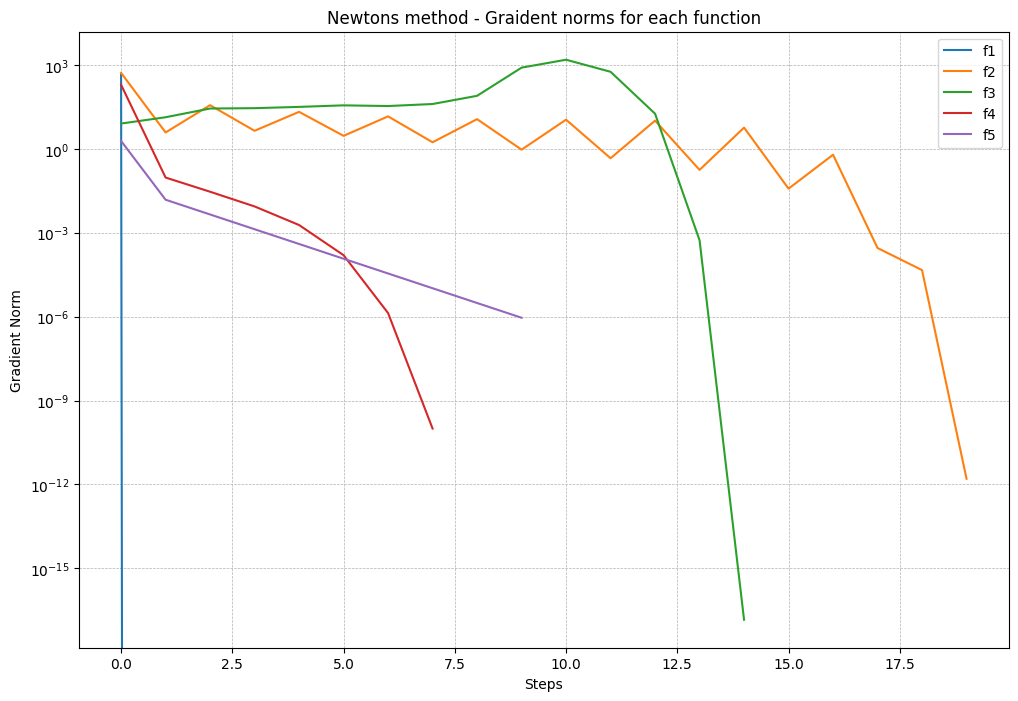

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(5,10):
    plt.plot(range(len(df_results.iloc[i,7])), df_results.iloc[i,7], label=f"{df_results.iloc[i,0]}")
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.title("Newtons method - Graident norms for each function")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [9]:
grad_norms = df_results["Gradient Norms"]
grad_norms[0]

[714.9090704542632,
 681.3991027612459,
 649.4599776949401,
 619.0180648422684,
 590.0031853435206,
 562.3484501065406,
 535.9901056048791,
 510.8673869044295,
 486.9223775797196,
 464.09987619692157,
 442.3472690557772,
 421.6144088970654,
 401.85349929599073,
 383.01898447498075,
 365.0674442818724,
 347.9574940913747,
 331.64968939904736,
 316.10643488784837,
 301.2918977576191,
 287.17192511769787,
 273.7139652522233,
 260.88699257661415,
 248.66143611222236,
 237.00911131426616,
 225.90315509587958,
 215.31796389848358,
 205.22913466570452,
 195.61340858476134,
 186.44861746561932,
 177.71363263429117,
 169.38831622245985,
 161.45347474112123,
 153.89081483121,
 146.68290108918947,
 139.81311587036717,
 133.26562097725872,
 127.0253211446639,
 121.07782923726089,
 115.4094330794705,
 110.00706384110246,
 104.85826590588063,
 99.95116815335945,
 95.27445658799971,
 90.81734825227312,
 86.56956636362231,
 82.52131661791896,
 78.6632646047475,
 74.98651428239913,
 71.48258746289692,


In [13]:
print(sd_result[-1])
print(nm_result[-1])

[0.6202636632834707, 0.0011598040721704425, 0.001099896289621338, 0.0009920058234778736, 0.0008156698414912263, 0.0005733510254924257, 0.00032160779316579326, 0.00014204661482144837, 5.377775421272066e-05, 1.92892559914854e-05, 6.83745198214078e-06, 2.4184867843930895e-06, 8.551299764082729e-07]
[0.6202636632834707, 0.0003530080801094419, 0.00010459498669909387, 3.0991107170101896e-05, 9.182550272622784e-06, 2.720755636332678e-06, 8.061498181726454e-07]
